**Table of Contents**  
[Parameters](#parameters)  
[Data preparation](#data_preparation)  
&nbsp; &nbsp; &nbsp; &nbsp;[Data loading](#data_loading)  
&nbsp; &nbsp; &nbsp; &nbsp;[Median normalization](#median_normalization)  
[Dimensionality reduction](#dimensionality_reduction)  
&nbsp; &nbsp; &nbsp; &nbsp;[PCA](#pca)  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;[Batch effect removal](#batch_effect_removal)  
&nbsp; &nbsp; &nbsp; &nbsp;[FIt-SNE](#fit-sne)  
&nbsp; &nbsp; &nbsp; &nbsp;[UMAP](#umap)  
[Clustering](#clustering)  
[Visualization](#visualization)  
&nbsp; &nbsp; &nbsp; &nbsp;[Cluster embedding](#cluster_embedding)  
&nbsp; &nbsp; &nbsp; &nbsp;[Cluster_distribution](#cluster_distribution)  
&nbsp; &nbsp; &nbsp; &nbsp;[Expression](#expression)  

In [1]:
!date +%F

2020-12-07


In [2]:
import sys
sys.path.append('/Users/jialei/Dropbox/Data/Projects/UTSW/Scripts/utilities')
sys.path.append('/project/GCRB/Hon_lab/s166631/00.bin/utilities/')

In [3]:
import re
import scipy.sparse
import numpy as np
import pandas as pd
from pathlib import Path

In [4]:
import umap
import harmonypy as hm
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import __version__ as sklearn_version
from matplotlib import __version__ as mpl_version

from fast_tsne import fast_tsne
from utilities import (
    plot_pca_variance_explained,
    plot_pca_corr,
    plot_embedding,
    prepare_cluster_composition,
    plot_cluster_composition,
    plot_embedding_expr,
    extract_feature_values
)

In [6]:
print(sys.version)
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('scipy', scipy.__version__)
print('sklearn', sklearn_version)
print('matplotlib', mpl_version)
print('seaborn', sns.__version__)

print('umap', umap.__version__)
print('scanpy', sc.__version__)

3.8.2 (default, May 23 2020, 03:35:41) 
[Clang 11.0.3 (clang-1103.0.32.62)]
numpy 1.19.2
pandas 1.1.2
scipy 1.4.1
sklearn 0.23.2
matplotlib 3.3.2
seaborn 0.11.0
umap 0.4.6
scanpy 1.6.0


In [7]:
# mpl.rcParams.update(mpl.rcParamsDefault)
# plt.rcParams
params = {'pdf.fonttype': 42,
          'font.family': 'sans-serif',
          'font.sans-serif': 'Arial',
          'mathtext.default': 'regular',
          'figure.dpi': 96 * 1.5,
          'axes.axisbelow': True}
plt.rcParams.update(params)
%config InlineBackend.figure_format = 'retina'

<a id='parameters'></a>

# Parameters

In [8]:
PROJECT_DIR = Path('/Users/jialei/Dropbox/Data/Projects/UTSW/Human_blastoid')

SEED = 20200416
N_COMPONENTS = 50
N_COMPONENTS_SELECTED = 24

MIN_GENES_THRESHOLD = 200
MINIMAL_NUM_CELLS_REQUIRED_FOR_GENE = 30
MINIMAL_NUM_COUNTS_REQUIRED_FOR_GENE = 60

N_THREADS = 4

<a id='data_preparation'></a>

# Data preparation

<a id='data_loading'></a>

## Data loading

In [9]:
# Part 3
DATA_DIR = PROJECT_DIR / 'github/data/matrices' / 'LW58_LW59_LW60_LW61'

matrix_readcount_p3 = scipy.sparse.load_npz(
    file=DATA_DIR / 'matrix_readcount.npz')

matrix_readcount_p3_barcodes = np.load(
    file=DATA_DIR / 'matrix_readcount_barcodes.npy')

matrix_readcount_p3_features = np.load(
    file=DATA_DIR / 'matrix_readcount_features.npy')

cells_included = [i.rstrip()
                  for i in open(file=DATA_DIR / 'cells_passed_mt_filtering.txt')]
_, = np.where([i.rstrip().startswith(('LW60',
                                      'LW61')) for i in cells_included])
cells_included = np.array(cells_included)[_]
cells_included_idx, = np.where(np.isin(element=matrix_readcount_p3_barcodes,
                                       test_elements=cells_included))

matrix_readcount_p3_barcodes = matrix_readcount_p3_barcodes[
    cells_included_idx]
matrix_readcount_p3 = matrix_readcount_p3[:, cells_included_idx]

In [10]:
# Part 4
DATA_DIR = PROJECT_DIR / 'raw/public' / 'PRJEB11202/reformatted_matrix'

matrix_readcount_p4 = scipy.sparse.load_npz(
    file=DATA_DIR / 'matrix_readcount.npz')

matrix_readcount_p4_barcodes = np.load(
    file=DATA_DIR / 'matrix_readcount_barcodes.npy')

matrix_readcount_p4_features = np.load(
    file=DATA_DIR / 'matrix_readcount_features.npy')

In [11]:
# Merge
matrix_readcount_use = scipy.sparse.hstack(
    blocks=(
        # matrix_readcount_p1,
        # matrix_readcount_p2,
        matrix_readcount_p3,
        matrix_readcount_p4
    ),
    format=None, dtype=np.int_).tocsc()

matrix_readcount_use_barcodes = np.concatenate(
    (
        # matrix_readcount_p1_barcodes,
        # matrix_readcount_p2_barcodes,
        matrix_readcount_p3_barcodes,
        matrix_readcount_p4_barcodes
    ), axis=0)

assert len(matrix_readcount_p3_features) == len(matrix_readcount_p4_features)
matrix_readcount_use_features = matrix_readcount_p3_features

matrix_readcount_use = matrix_readcount_use[
    :,
    np.argsort(a=matrix_readcount_use_barcodes)]
matrix_readcount_use_barcodes = matrix_readcount_use_barcodes[
    np.argsort(a=matrix_readcount_use_barcodes)]

In [12]:
# Clean up
del matrix_readcount_p3
del matrix_readcount_p3_barcodes
del matrix_readcount_p3_features

del matrix_readcount_p4
del matrix_readcount_p4_barcodes
del matrix_readcount_p4_features

<a id='median_normalization'></a>

## Median normalization

In [13]:
matrix_readcount_norm = matrix_readcount_use.copy()
print(
    'Raw median UMIs per cell:',
    f'{np.median(a=matrix_readcount_use.sum(axis=0).A1)}'
)
print(f'Number of cells before filtering: {matrix_readcount_norm.shape[1]}')
print(f'Number of features before filtering: {matrix_readcount_norm.shape[0]}')

# filter cells
(col_idx,) = np.where(
    (matrix_readcount_norm > 0).sum(axis=0).A1 >= MIN_GENES_THRESHOLD
)
matrix_readcount_norm = matrix_readcount_norm[:, col_idx]
matrix_readcount_norm_barcodes = matrix_readcount_use_barcodes[col_idx]
print(
    f'Number of cells after filtering: {len(matrix_readcount_norm_barcodes)}')

# filter features
row_idx = np.logical_and(
    (matrix_readcount_norm > 0).sum(
        axis=1).A1 >= MINIMAL_NUM_CELLS_REQUIRED_FOR_GENE,
    (matrix_readcount_norm).sum(
        axis=1).A1 >= MINIMAL_NUM_COUNTS_REQUIRED_FOR_GENE,
)

matrix_readcount_norm = matrix_readcount_norm[row_idx, :]
matrix_readcount_norm_features = matrix_readcount_use_features[row_idx]
print('Number of features after filtering: ',
      f'{len(matrix_readcount_norm_features)}')
print('After filtering, median UMIs per cell is',
      f'{np.median(a=matrix_readcount_norm.sum(axis=0).A1)}'
      )

# normalize
matrix_readcount_norm.data = (
    np.median(a=matrix_readcount_norm.sum(axis=0).A1)
    * matrix_readcount_norm.data
    / np.repeat(matrix_readcount_norm.sum(axis=0).A1,
                np.diff(matrix_readcount_norm.indptr))
)

Raw median UMIs per cell: 11410.0
Number of cells before filtering: 11182
Number of features before filtering: 33538
Number of cells after filtering: 11182
Number of features after filtering:  23617
After filtering, median UMIs per cell is 11409.0


<a id='dimensionality_reduction'></a>

# Dimensionality reduction

In [14]:
batches = [re.sub('_[A-Z]{16}$', '', i)
           for i in matrix_readcount_norm_barcodes]

_, = np.where([i.rstrip().startswith(('ER',))
               for i in batches])

batches = np.array(batches)
batches[_] = 'PRJEB11202'

print(sorted(set(batches)))

['LW60', 'LW61', 'PRJEB11202']


In [15]:
# create anndata object, logarithmized
adata = sc.AnnData(
    X=np.log1p(matrix_readcount_norm.T),
    obs={
        'cell': matrix_readcount_norm_barcodes,
        'batch': batches,
    },
    var={'feature': matrix_readcount_norm_features},
)
adata.obs.index = adata.obs['cell']
adata.var.index = adata.var['feature']

adata.var['symbol'] = [re.sub('^E[A-Z]{1,}[0-9]{11}_', '', i)
                       for i in adata.var['feature']]

In [16]:
adata.obs['num_umis'] = matrix_readcount_use.sum(axis=0).A1
adata.obs['num_features'] = (adata.X > 0).sum(axis=1).A1
_, = np.where([i.startswith('MT-') for i in adata.var.symbol])
adata.obs['num_umis_mt'] = matrix_readcount_use[_, :].sum(axis=0).A1

adata.obs.head()

,cell,batch,num_umis,num_features,num_umis_mt
cell,,,,,
ERS1079290,ERS1079290,PRJEB11202,1884175,10365,1906
ERS1079291,ERS1079291,PRJEB11202,1290557,8834,1226
ERS1079292,ERS1079292,PRJEB11202,1686855,10739,2271
ERS1079293,ERS1079293,PRJEB11202,1181562,9751,1529
ERS1079294,ERS1079294,PRJEB11202,1868361,10460,1893


In [17]:
# standardize
sc.pp.scale(adata, zero_center=True, max_value=None, copy=False)

 <a id='pca'></a>

## PCA

In [18]:
# PCA
pca = PCA(
    n_components=N_COMPONENTS,
    copy=True,
    whiten=False,
    svd_solver='arpack',
    tol=0.0,
    iterated_power='auto',
    random_state=SEED,
)
principal_components = pca.fit_transform(adata.X)

/Users/jialei/Dropbox/Data/Projects/UTSW/Scripts/utilities/utilities.py:266: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=['{:,.1%}'.format(i) for i in ax.get_yticks()])


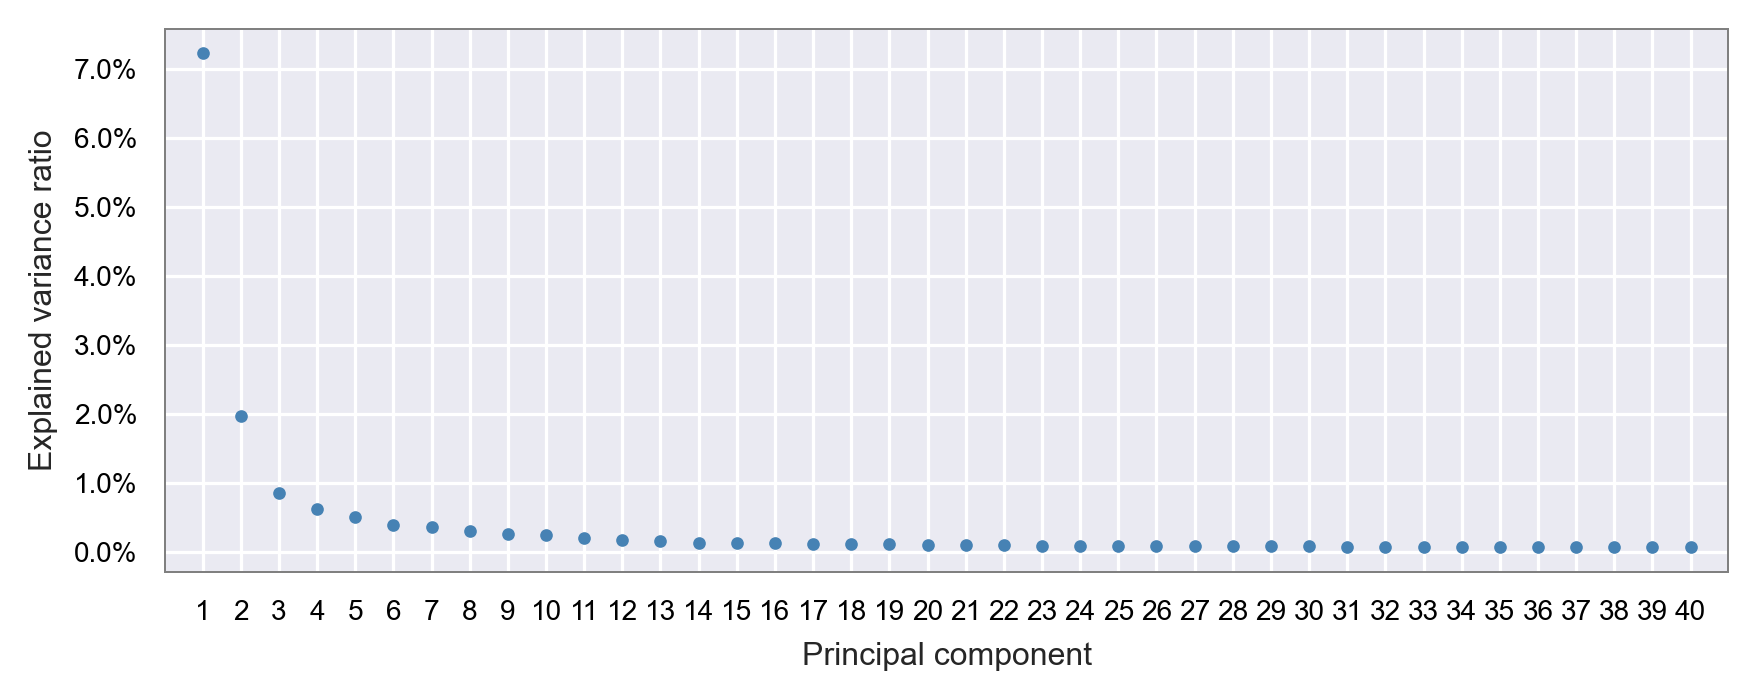

In [19]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 2.5))

    plot_pca_variance_explained(
        explained_variance_ratio=pca.explained_variance_ratio_,
        maximum_num_pcs=min(40, N_COMPONENTS),
        ax=ax
    )

In [20]:
file_name = ('Pyplot_pca_explained_var_ratio'
             + '_ncomponents'
             + str(N_COMPONENTS)
             + '_seed'
             + str(SEED)
             + '.pdf')

if not Path(file_name).is_file():
    fig.savefig(fname=file_name, transparent=None, bbox_inches='tight')

In [21]:
N_COMPONENTS_CORR = min(40, N_COMPONENTS)

corr_pearsonr = [scipy.stats.pearsonr(
    x=principal_components[:, i],
    y=np.log1p(matrix_readcount_use[:, col_idx].sum(axis=0).A1),
)[0] for i in range(N_COMPONENTS_CORR)]

corr_pearsonr = pd.DataFrame(
    data=corr_pearsonr,
    columns=['corr']
)

_, = np.where([np.sqrt(i**2) <= 0.9
               for i in corr_pearsonr['corr']])
principal_components = principal_components[:, _]

<a id='batch_effect_removal'></a>

## Batch effect removal

In [22]:
batches = adata.obs['batch'].values
pd.Series(batches).value_counts()

LW61          5156
LW60          4497
PRJEB11202    1529
dtype: int64

In [23]:
ho = hm.run_harmony(
    data_mat=principal_components,
    meta_data=pd.DataFrame(
        {'batch': batches},
        index=matrix_readcount_norm_barcodes),
    vars_use='batch',
    random_state=SEED
)

principal_components_corrected = ho.Z_corr.T

2020-12-07 20:41:59,492 - harmonypy - INFO - Iteration 1 of 10
2020-12-07 20:42:02,497 - harmonypy - INFO - Iteration 2 of 10
2020-12-07 20:42:05,268 - harmonypy - INFO - Iteration 3 of 10
2020-12-07 20:42:07,983 - harmonypy - INFO - Iteration 4 of 10
2020-12-07 20:42:10,729 - harmonypy - INFO - Iteration 5 of 10
2020-12-07 20:42:13,505 - harmonypy - INFO - Iteration 6 of 10
2020-12-07 20:42:16,269 - harmonypy - INFO - Iteration 7 of 10
2020-12-07 20:42:18,353 - harmonypy - INFO - Iteration 8 of 10
2020-12-07 20:42:21,131 - harmonypy - INFO - Iteration 9 of 10
2020-12-07 20:42:23,611 - harmonypy - INFO - Converged after 9 iterations


In [24]:
principal_components_use = principal_components_corrected[
    :, range(N_COMPONENTS_SELECTED)
]

<a id='fit-sne'></a>

## FIt-SNE

In [25]:
embedding_initialization = umap.UMAP(
    n_neighbors=10,
    n_components=N_COMPONENTS,
    metric='euclidean',
    min_dist=0.1,
    spread=1.0,
    random_state=SEED,
    transform_seed=42,
    verbose=True,
).fit_transform(principal_components_use)

embedding_fitsne = fast_tsne(
    X=principal_components_use,
    theta=0.5,
    perplexity=30,
    max_iter=2000,
    map_dims=2,
    seed=SEED,
    initialization=embedding_initialization,
    df=1.0,
    nthreads=N_THREADS,
)

UMAP(n_components=50, n_neighbors=10, random_state=20200416, verbose=True)
Construct fuzzy simplicial set
Mon Dec  7 20:42:23 2020 Finding Nearest Neighbors
Mon Dec  7 20:42:23 2020 Building RP forest with 10 trees
Mon Dec  7 20:42:24 2020 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
Mon Dec  7 20:42:35 2020 Finished Nearest Neighbor Search
Mon Dec  7 20:42:37 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Dec  7 20:42:49 2020 Finished embedding


<a id='umap'></a>

## UMAP

In [26]:
embedding_umap = umap.UMAP(
    n_neighbors=20,
    n_components=2,
    metric='euclidean',
    n_epochs=None,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    random_state=SEED,
    transform_seed=42,
    verbose=True,
).fit_transform(principal_components_use)

UMAP(n_neighbors=20, random_state=20200416, verbose=True)
Construct fuzzy simplicial set
Mon Dec  7 20:50:23 2020 Finding Nearest Neighbors
Mon Dec  7 20:50:23 2020 Building RP forest with 10 trees
Mon Dec  7 20:50:23 2020 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
Mon Dec  7 20:50:24 2020 Finished Nearest Neighbor Search
Mon Dec  7 20:50:24 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Dec  7 20:50:33 2020 Finished embedding


<a id='clustering'></a>

# Clustering

In [27]:
# clustering
adata = sc.AnnData(
    X=principal_components_use,
    obs=adata.obs,
)

In [28]:
sc.pp.neighbors(
    adata=adata,
    n_neighbors=30,
    n_pcs=0,
    use_rep=None,
    knn=True,
    random_state=SEED,
    method='umap',
    metric='euclidean',
    copy=False,
)

In [29]:
sc.tl.louvain(
    adata=adata,
    resolution=1,
    random_state=SEED,
    flavor='vtraag',
    directed=True,
    use_weights=False,
    partition_type=None,
    copy=False,
)

In [30]:
adata.obs['louvain'].value_counts().to_frame(name='num_cells')

,num_cells
0,1533
1,1113
2,1079
3,996
4,924
5,725
6,710
7,672
8,649
9,570


In [31]:
embedding = pd.DataFrame(
    data=np.concatenate(
        (
            adata.obs[['batch', 'louvain']],
            embedding_fitsne,
            embedding_umap
        ),
        axis=1,
    ),
    index=adata.obs['cell'],
    columns=[
        'batch',
        'louvain',
        'x_fitsne',
        'y_fitsne',
        'x_umap',
        'y_umap'
    ],
)

<a id='visualization'></a>

# Visualization

<a id='cluster_embedding'></a>

## Clustering embedding

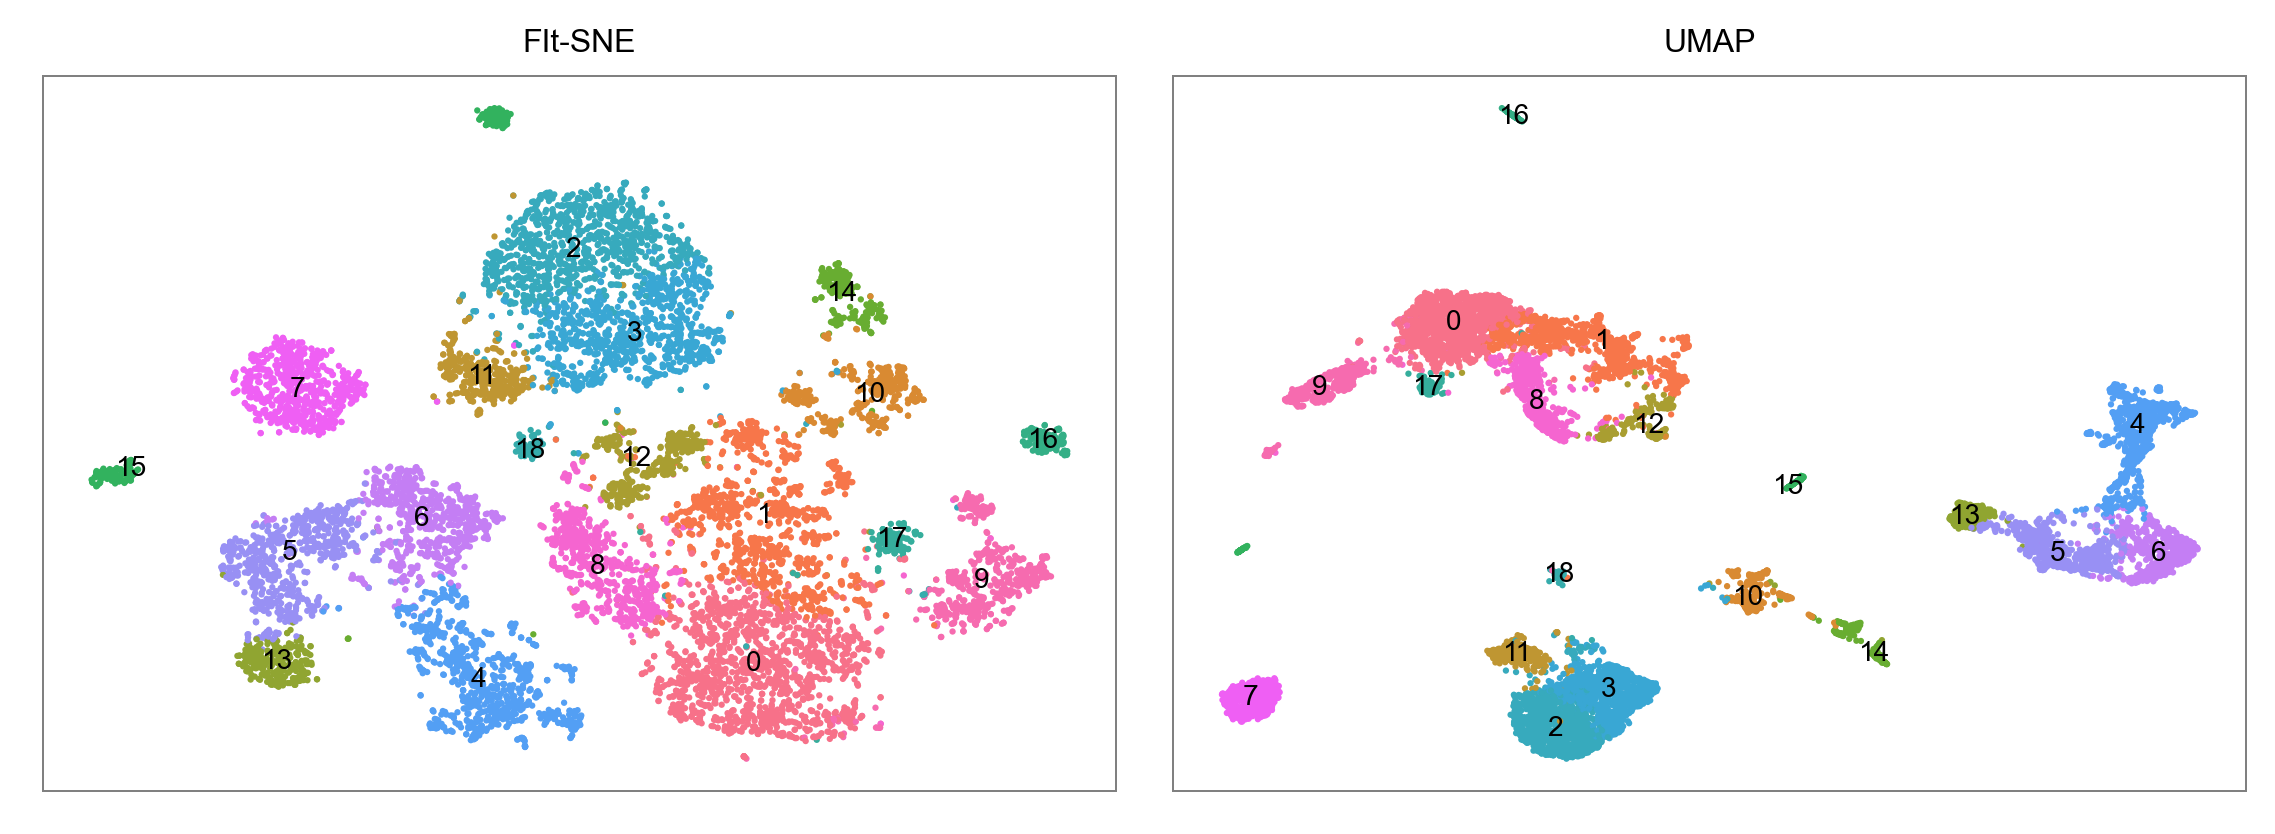

In [32]:
fig, axes = plt.subplots(nrows=1 * 1, ncols=1 * 2, figsize=(4 * 2, 3 * 1))
axes = axes.flatten()

plot_embedding(
    embedding=embedding_fitsne,
    ax=axes[0],
    title='FIt-SNE',
    group=adata.obs['louvain'],
    show_group_labels=True,
)

plot_embedding(
    embedding=embedding_umap,
    ax=axes[1],
    title='UMAP',
    group=adata.obs['louvain'],
    show_group_labels=True,
)

plt.tight_layout()

<a id='expression'></a>

<a id='cluster_distribution'></a>

## Cluster distribution

In [33]:
embedding.groupby(by='batch').size().to_frame(name='num_cells')

,num_cells
batch,
LW60,4497
LW61,5156
PRJEB11202,1529


In [34]:
louvain_order = np.sort(embedding['louvain'].unique().astype(
    dtype=np.int_)).astype(dtype=str)[::-1]
louvain_order = list(louvain_order)
batch_order = list(embedding['batch'].unique())

/Users/jialei/Dropbox/Data/Projects/UTSW/Scripts/utilities/utilities.py:562: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=['{:.0%}'.format(i)


<AxesSubplot:ylabel='Cluster'>

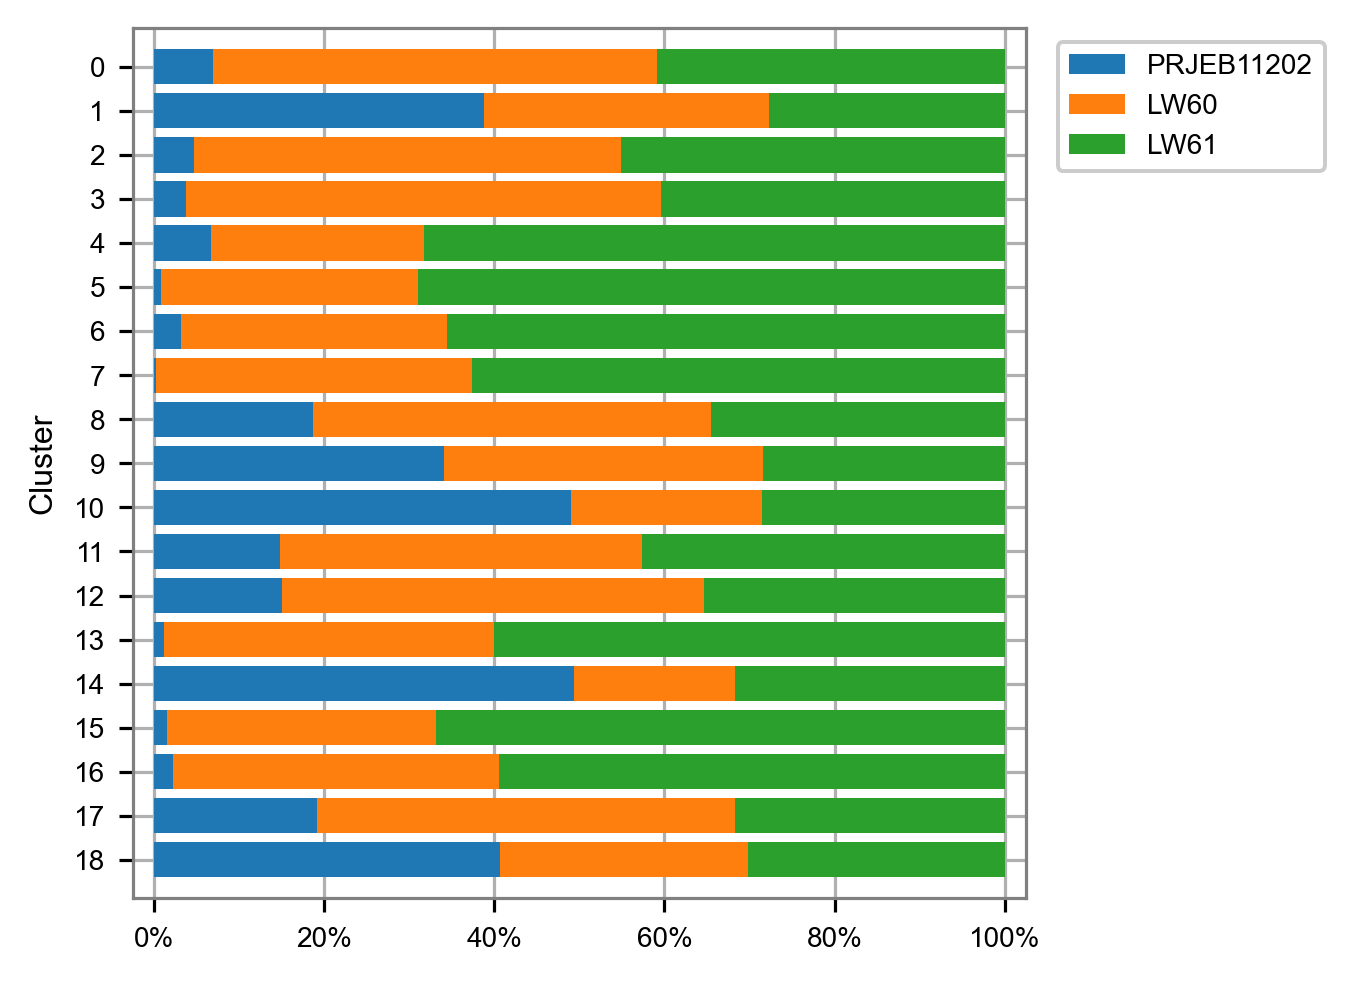

In [35]:
cluster_composition = prepare_cluster_composition(
    embedding=embedding,
    cluster_column='louvain',
    composition_column='batch',
    cluster_column_order=louvain_order,
    composition_column_order=batch_order
)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

plot_cluster_composition(
    cluster_composition=cluster_composition,
    x='batch',
    y='louvain',
    ax=ax,
    x_order=batch_order,
    y_order=louvain_order
)

## Expression

In [36]:
# calculate CPM
matrix_cpm_use = matrix_readcount_use.copy()
matrix_cpm_use.data = (
    1_000_000
    * matrix_cpm_use.data
    / np.repeat(matrix_cpm_use.sum(axis=0).A1, np.diff(matrix_cpm_use.indptr))
)

# create anndata object, CPM
adata_cpm = sc.AnnData(
    X=matrix_cpm_use.T,
    obs={
        'cell': matrix_readcount_use_barcodes,
        'batch': [re.sub('_[A-Z]{16}$', '', i) for i in matrix_readcount_use_barcodes],
    },
    var={'feature': matrix_readcount_use_features},
)

adata_cpm.obs.index = adata_cpm.obs['cell']
adata_cpm.var.index = adata_cpm.var['feature']

In [37]:
FEATURES_SELECTED = [
    'ENSG00000181449_SOX2',
    'ENSG00000156574_NODAL',
    'ENSG00000111704_NANOG',
    'ENSG00000147596_PRDM14',
    'ENSG00000075388_FGF4',
    'ENSG00000164736_SOX17',
    'ENSG00000125798_FOXA2',
    'ENSG00000136574_GATA4',
    'ENSG00000141448_GATA6',
    'ENSG00000115414_FN1',
    'ENSG00000187498_COL4A1',
    'ENSG00000179348_GATA2',
    'ENSG00000107485_GATA3',
    'ENSG00000118777_ABCG2',
    'ENSG00000126353_CCR7',
    'ENSG00000137869_CYP19A1',
    'ENSG00000169550_MUC15'
]

SOX2


/Users/jialei/.pyenv/versions/3.8.2/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


NODAL
NANOG
PRDM14
FGF4
SOX17
FOXA2
GATA4
GATA6
FN1
COL4A1
GATA2
GATA3
ABCG2
CCR7
CYP19A1
MUC15


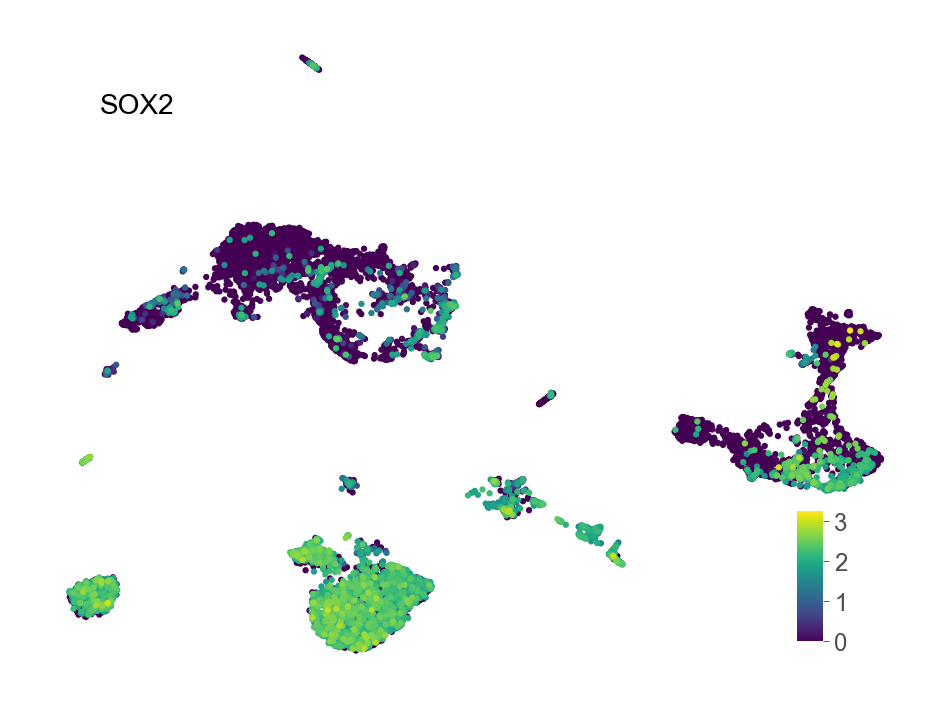

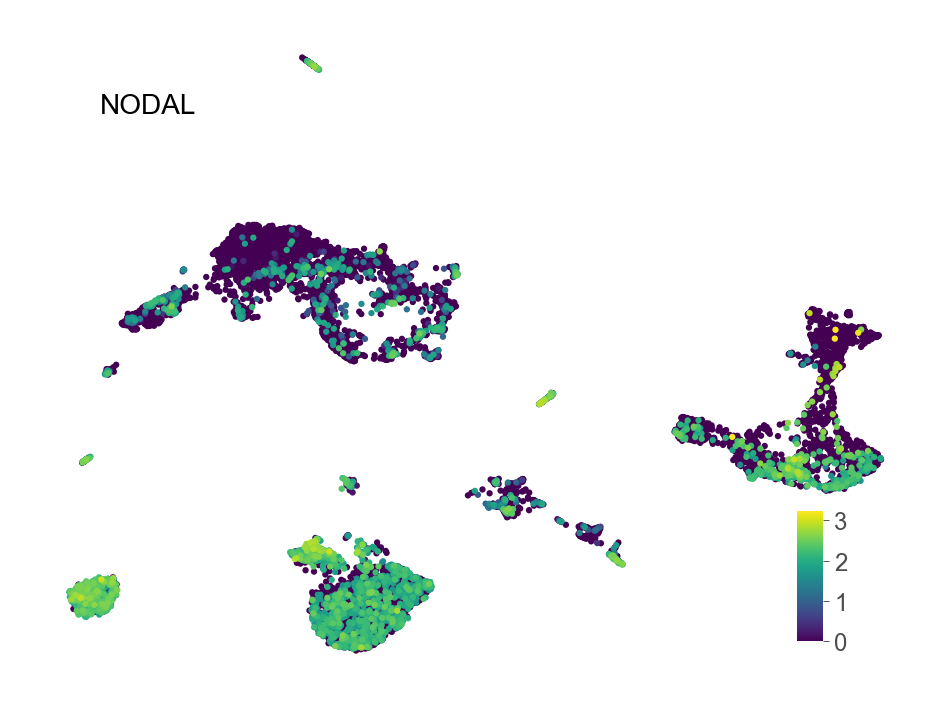

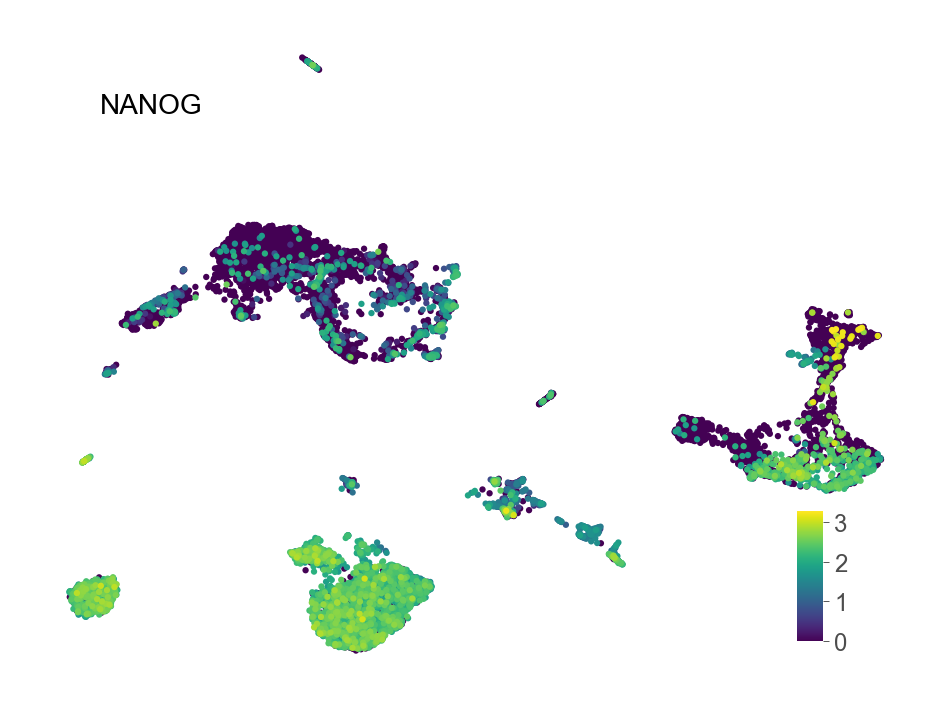

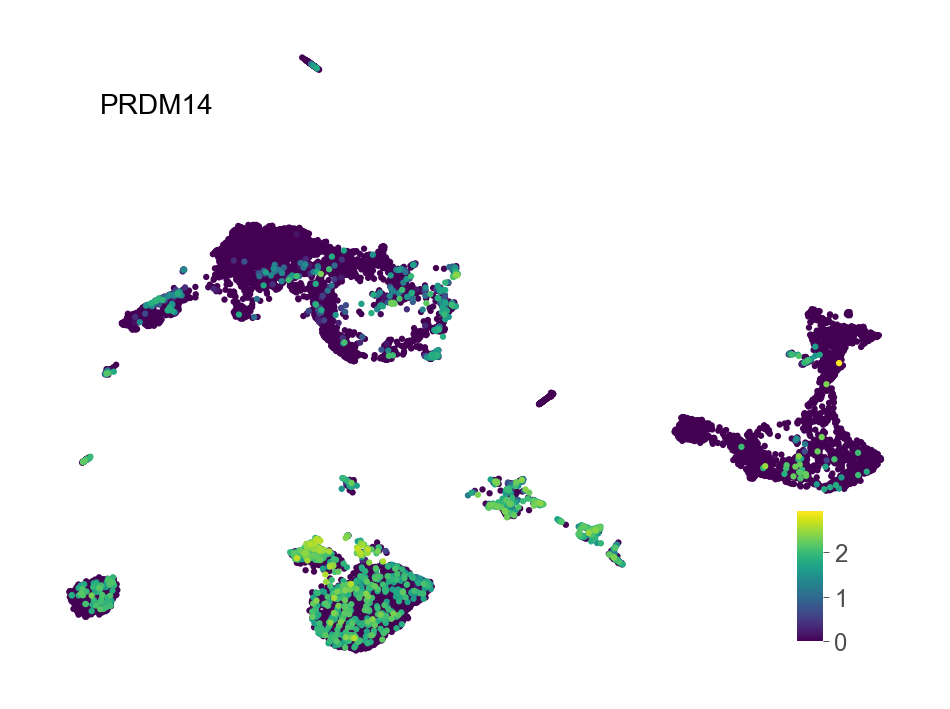

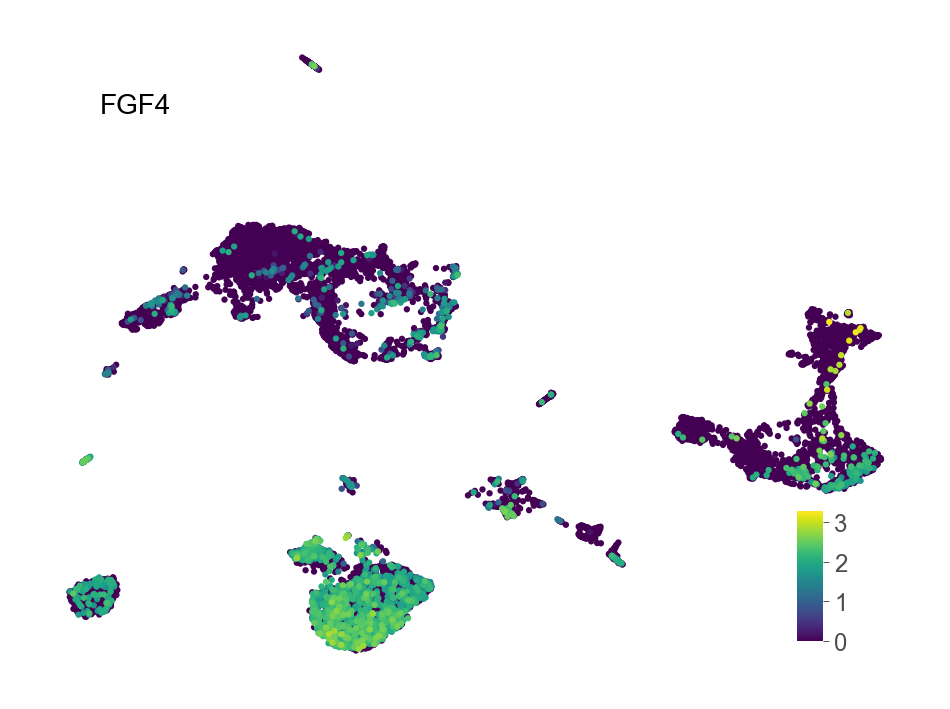

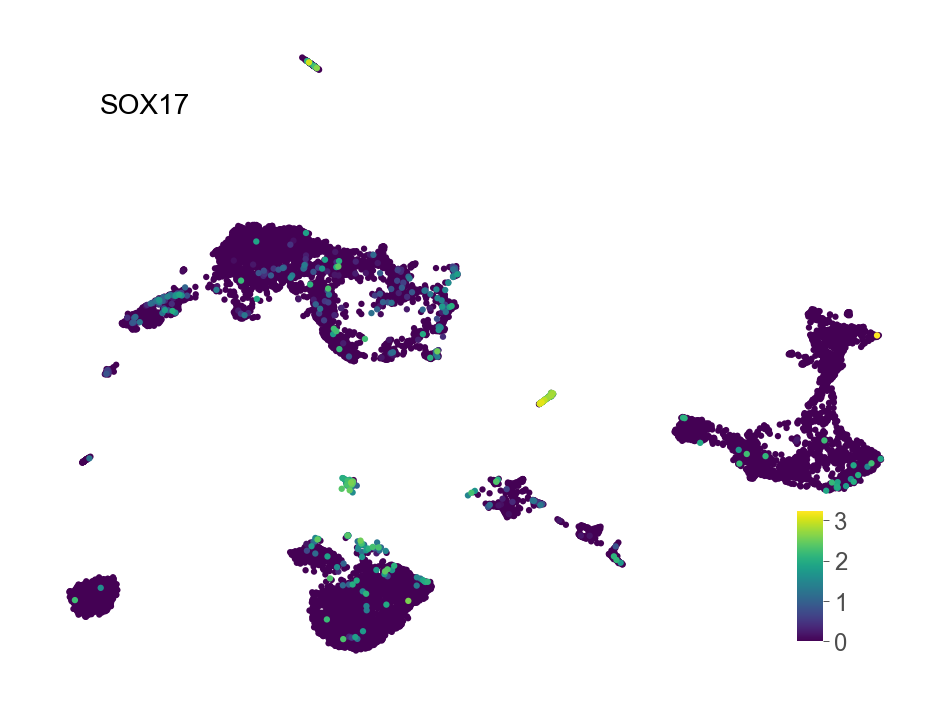

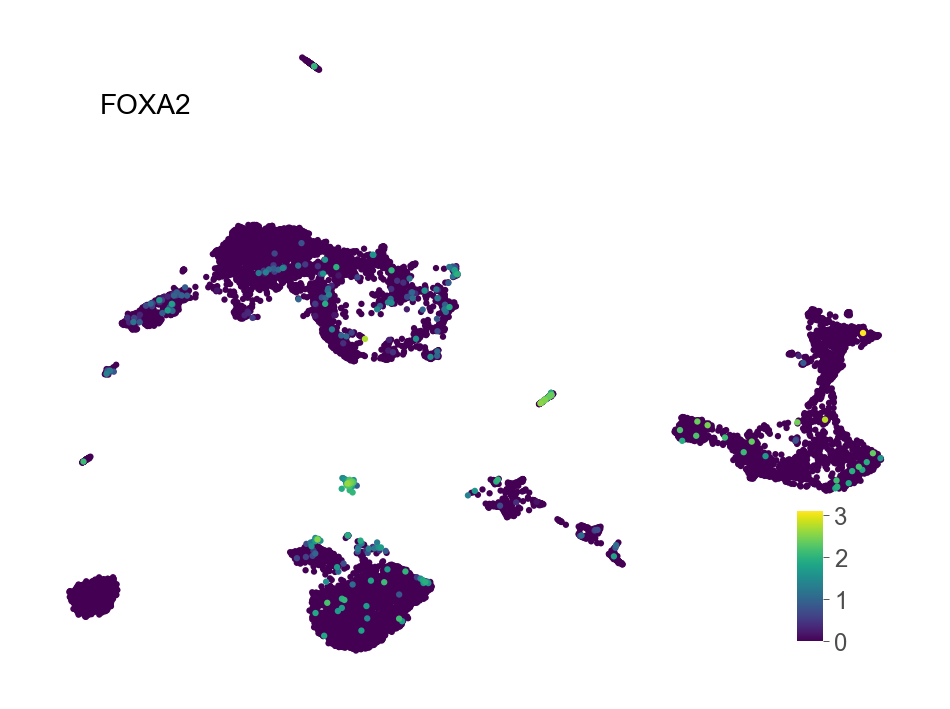

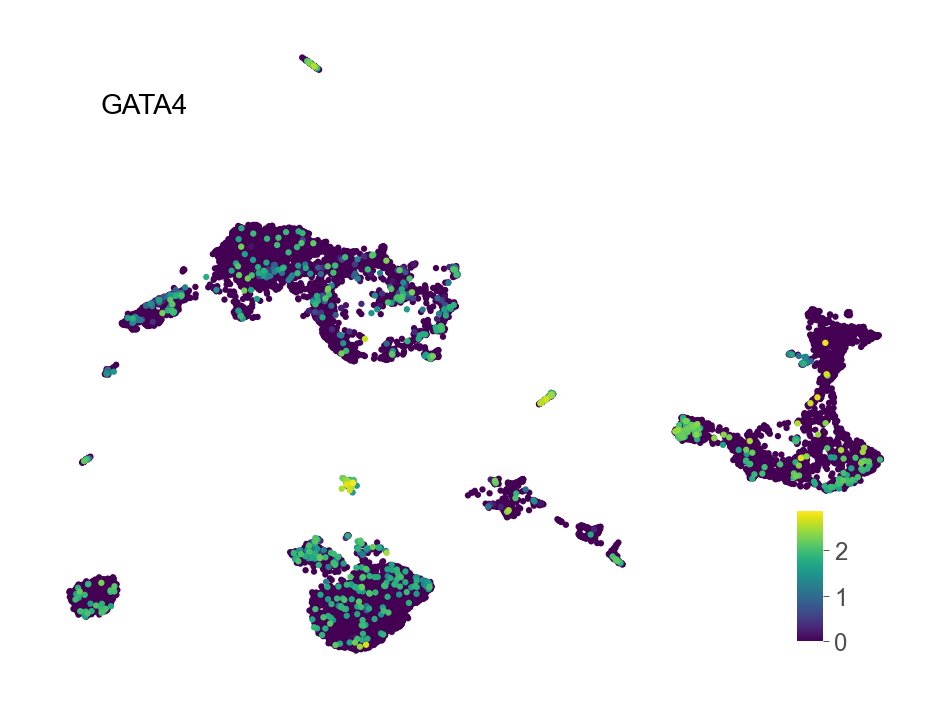

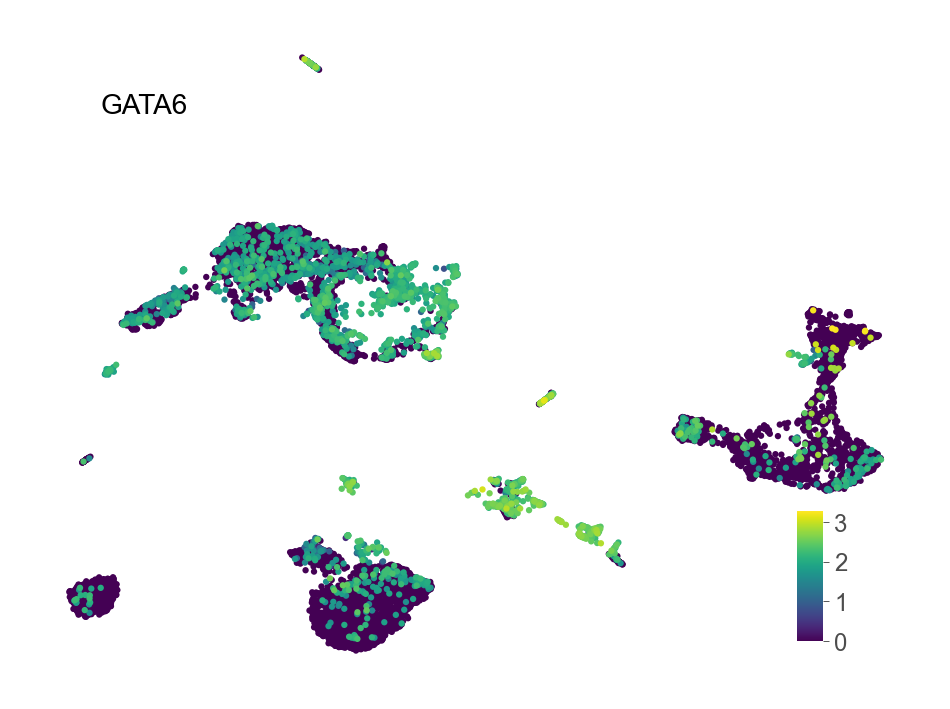

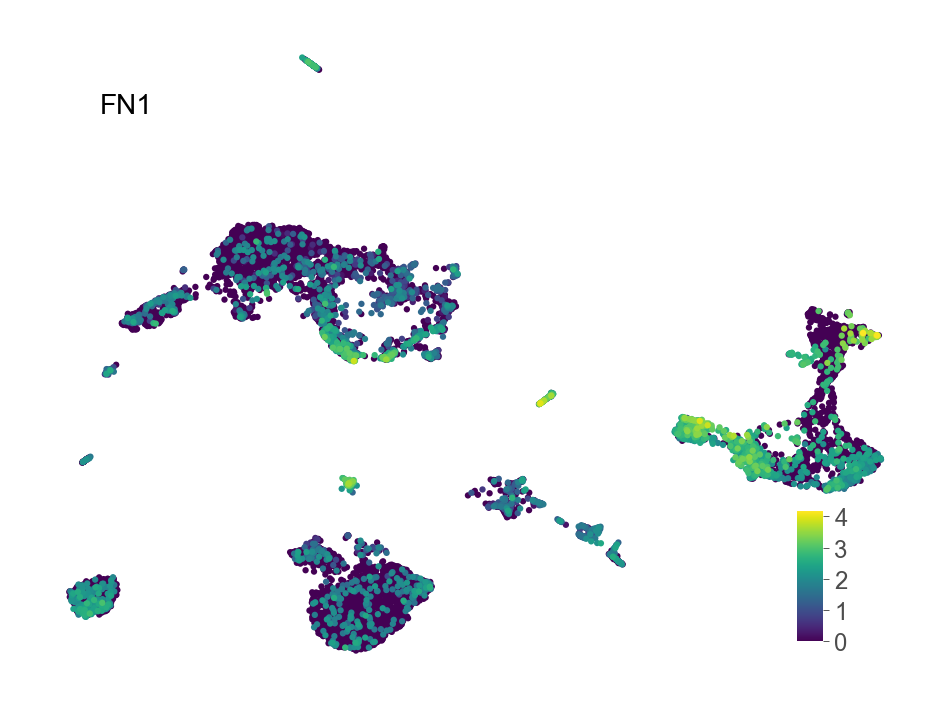

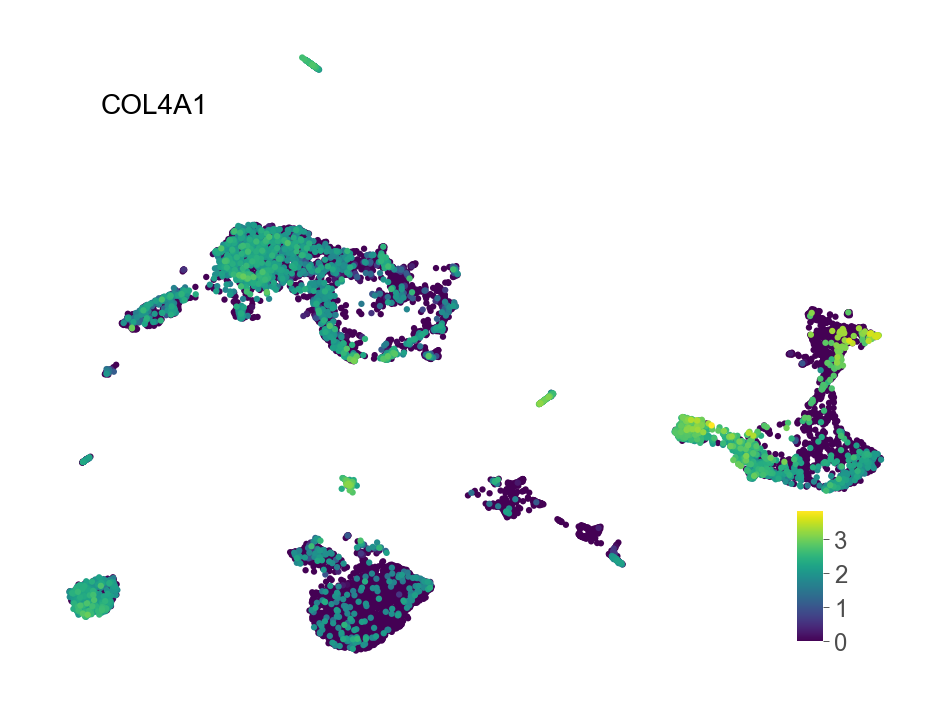

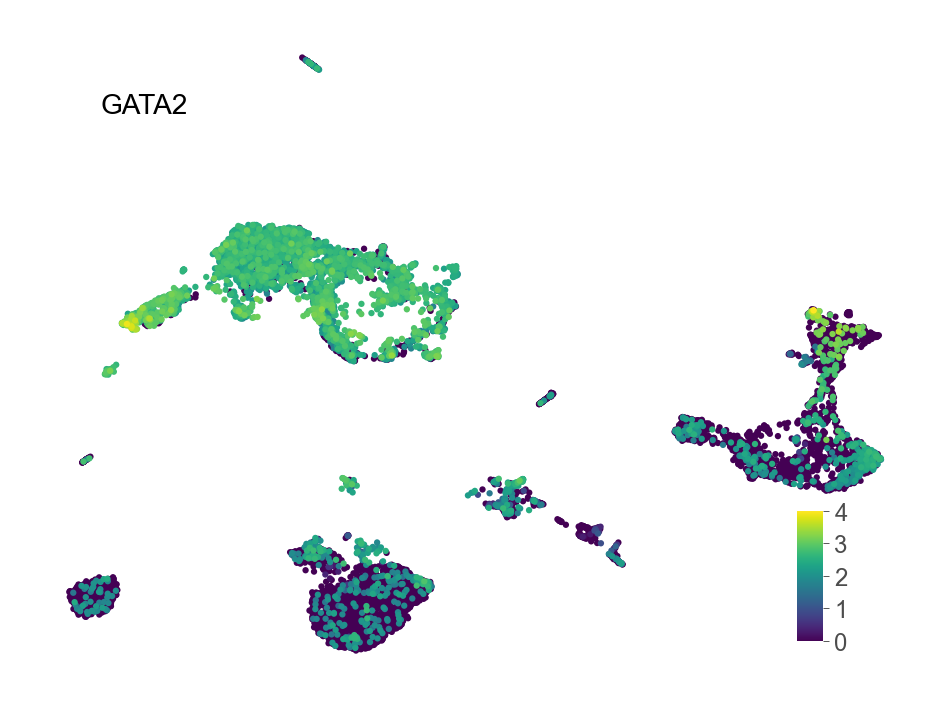

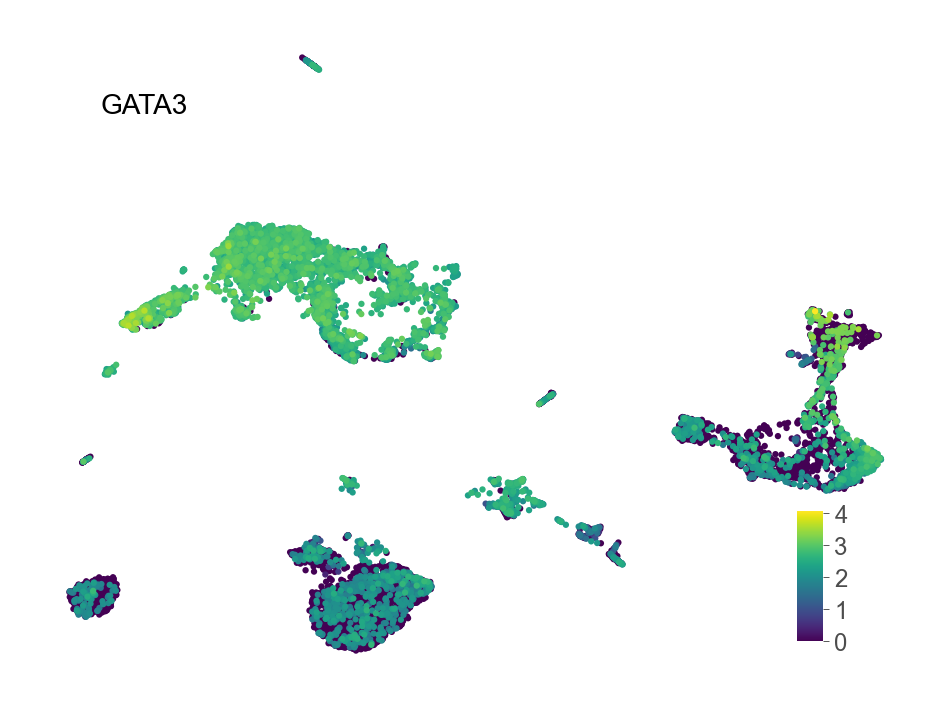

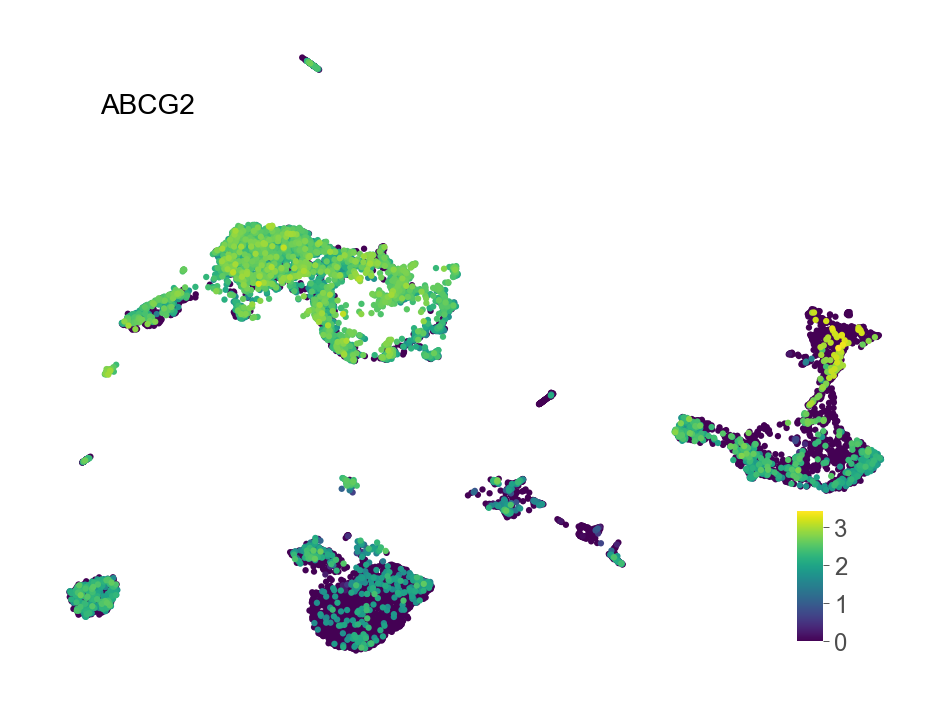

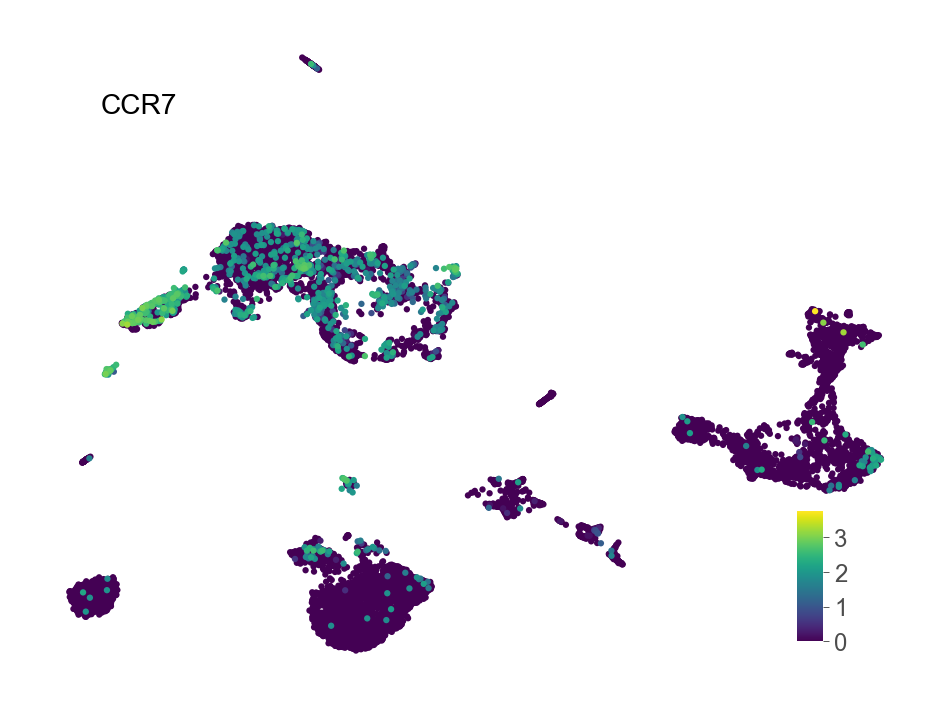

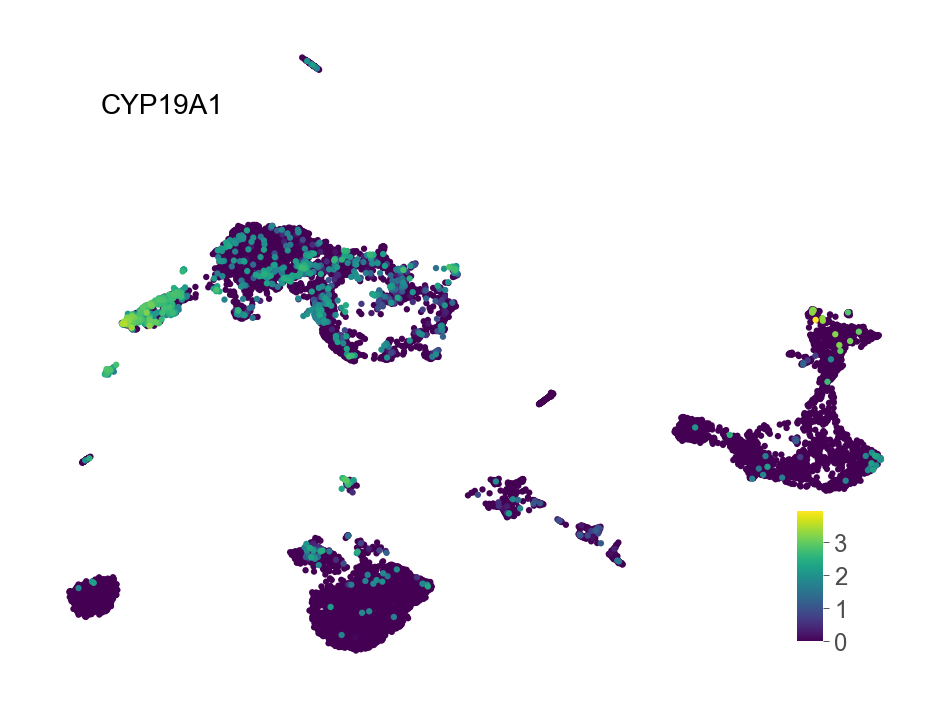

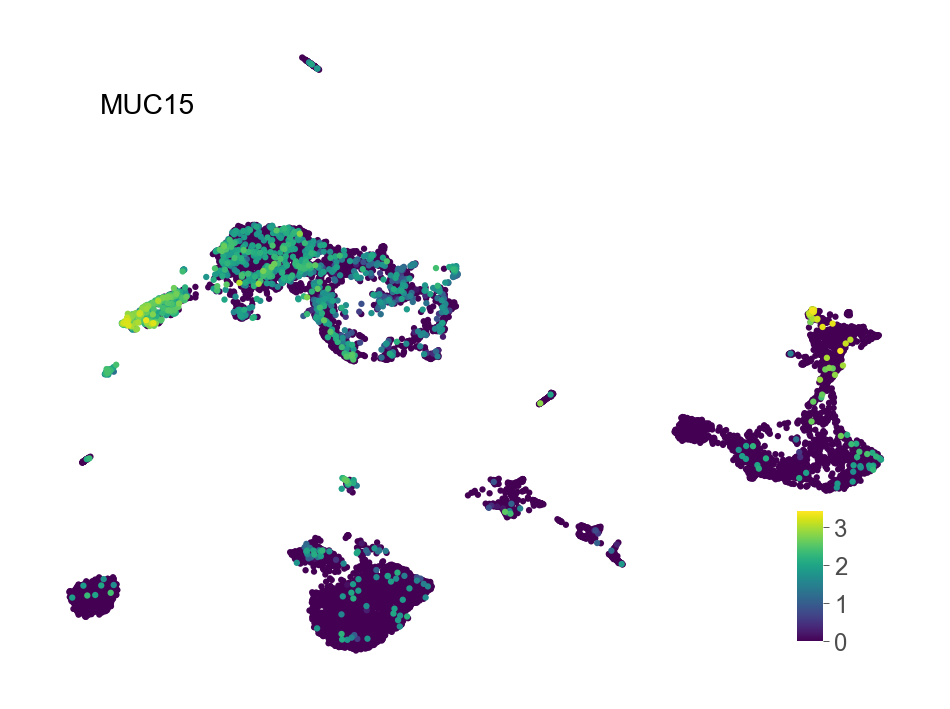

In [38]:
for i in FEATURES_SELECTED:
    print(i.split('_')[1])

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4 * 1, 3 * 1))

    plot_embedding_expr(
        embedding=embedding.loc[:, ['x_umap', 'y_umap']],
        expr=extract_feature_values(
            adata=adata_cpm,
            feature_name=i,
            cells_included=embedding.index,
        ),
        figure=fig,
        ax=ax,
        label=i.split('_')[1],
        label_position=(0.08, 0.9),
        colorbar_position=(0.86, 0.06, 0.03, 0.2)
    )